In [4]:
from load_data import load_data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch 
import numpy as np

Paper: [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf)

There are like a million ways to explain variational autoencoders that are needlessly complicated. Simply look at the loss function to see what is going on:

There is the constuction loss: how far from the input the generated image is 

Then there is the KL divergence loss which is a bit more complicated.
<ol>
    <li> mu and log_var are generated in the encoder, they are then compared to a smaple from a normal distrobution. 
    <li> Basically mu and log_var are penalized if they do not produce a normal distrobution with mean = 0 and std = 1.0
    <li> this "regularizes" the latent space to a normal distrobution

In [5]:
INPUT_DIMS = (28, 28)

In [6]:
class VAE(torch.nn.Module):
    def __init__(self, latent_dims = 16) -> None:
        super(VAE, self).__init__()

        # encoder
        self.encoder_conv_layers = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 32, (3, 3), stride = 2, padding = 1),
            torch.nn.Conv2d(32, 64, (3, 3), stride = 2, padding = 1)
        ])

        self.encoder_linear = torch.nn.Linear(7 * 7 * 64, 32)
        self.linear_mu = torch.nn.Linear(32, latent_dims)
        self.linear_log_var = torch.nn.Linear(32, latent_dims)

        # decoder
        self.decoder_linear = torch.nn.Linear(latent_dims, 7 * 7 * 64)

        self.decoder_transconv_layers = torch.nn.ModuleList([
            torch.nn.ConvTranspose2d(64, 32, 3, stride = 2, output_padding = 1, padding = 1),
            torch.nn.ConvTranspose2d(32, 32, 3, stride = 2, output_padding = 1, padding = 1), 
            torch.nn.ConvTranspose2d(32, 1, 3, stride = 1, padding = 1), 
        ])

    def encoder(self, input):
        x = self.encoder_conv_layers[0](input)
        x = F.leaky_relu(x)

        for layer in self.encoder_conv_layers[1:]:
            x = layer(x)
            x = F.leaky_relu(x)

        x = torch.flatten(x, start_dim = 1)

        x = self.encoder_linear(x)
        x = F.leaky_relu(x)

        mu = self.linear_mu(x)
        log_var = self.linear_log_var(x)

        epsilon = torch.randn_like(mu)

        sample = mu + torch.exp(log_var / 2) * epsilon
        return sample, mu, log_var

    def decoder(self, latent_space):
        x = self.decoder_linear(latent_space)
        x = F.leaky_relu(x)
        
        x = torch.reshape(x, (-1, 64, 7, 7))

        for layer in self.decoder_transconv_layers[:-1]:
            x = layer(x)
            x = F.leaky_relu(x)

        x = self.decoder_transconv_layers[-1](x)
        output = torch.sigmoid(x)
        
        return output

    def forward(self, input):
        latent_space, mu, log_var = self.encoder(input)
        output = self.decoder(latent_space)
        
        return output, mu, log_var

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

train_data, test_data = load_data() # load in data

epochs = 30
batch_size = 64

dkl_weight = 3e-3

latent_dims = 10

weight_decay  = 1e-5
lr_init = 1e-4

train = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
test = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

In [8]:
def loss_fn(output, input, mu, log_var):
    recon_loss = F.binary_cross_entropy(output, input)
    dkl_loss = -0.5 * torch.mean(torch.sum(1 + log_var - mu ** 2 - log_var.exp(), axis = 1))

    loss = dkl_loss * dkl_weight + recon_loss
    return loss, recon_loss, dkl_loss

model = VAE(latent_dims = latent_dims)

opt = torch.optim.Adam(
    model.parameters(), 
    lr = lr_init, 
    weight_decay = weight_decay
    ) 

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor = .2, patience = 1, verbose = True, cooldown = 5)

model.to(device)

VAE(
  (encoder_conv_layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (encoder_linear): Linear(in_features=3136, out_features=32, bias=True)
  (linear_mu): Linear(in_features=32, out_features=10, bias=True)
  (linear_log_var): Linear(in_features=32, out_features=10, bias=True)
  (decoder_linear): Linear(in_features=10, out_features=3136, bias=True)
  (decoder_transconv_layers): ModuleList(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [9]:
print(f'Training Started 0/{epochs} epochs')
for epoch in range(epochs):
    train_loss = 0 # init train loss to 0
    train_recon_loss = 0
    train_dkl_loss = 0

    for imgs, _ in tqdm(train, mininterval= 0.5):
        opt.zero_grad()

        imgs = imgs.to(device)
        
        outputs, mu, log_var = model(imgs)
        loss, recon_loss, dkl_loss = loss_fn(outputs, imgs, mu, log_var)
        
        loss.backward()
        opt.step()

        train_loss += loss.item() 
        train_recon_loss += recon_loss.item()
        train_dkl_loss += dkl_loss.item()

    test_loss = 0 
    with torch.no_grad():
        for imgs, _ in test:
            imgs = imgs.to(device)
            outputs, mu, log_var = model(imgs)
            loss, recon_loss, dkl_loss = loss_fn(outputs, imgs, mu, log_var)
            test_loss += loss.item() 
            
    train_loss /= len(train)
    train_dkl_loss /= len(train)
    train_recon_loss /= len(train)

    test_loss /= len(test)

    print(f"Epoch: {epoch + 1}/{epochs} complete\tTrain loss: {train_loss:.5f} Dkl loss: {train_dkl_loss:.5f} Recon loss: {train_recon_loss:.5f}\t Test loss: {test_loss:.5f}")

    scheduler.step(test_loss)

Training Started 0/30 epochs


100%|██████████| 938/938 [00:59<00:00, 15.67it/s]


Epoch: 1/30 complete	Train loss: 0.32843 Dkl loss: 5.75454 Recon loss: 0.31116	 Test loss: 0.24462


100%|██████████| 938/938 [01:00<00:00, 15.57it/s]


Epoch: 2/30 complete	Train loss: 0.22281 Dkl loss: 8.73614 Recon loss: 0.19661	 Test loss: 0.20718


100%|██████████| 938/938 [01:00<00:00, 15.48it/s]


Epoch: 3/30 complete	Train loss: 0.19995 Dkl loss: 10.48675 Recon loss: 0.16849	 Test loss: 0.19358


100%|██████████| 938/938 [00:58<00:00, 16.03it/s]


Epoch: 4/30 complete	Train loss: 0.19085 Dkl loss: 11.05122 Recon loss: 0.15770	 Test loss: 0.18767


100%|██████████| 938/938 [01:00<00:00, 15.52it/s]


Epoch: 5/30 complete	Train loss: 0.18546 Dkl loss: 11.31862 Recon loss: 0.15150	 Test loss: 0.18274


100%|██████████| 938/938 [00:59<00:00, 15.68it/s]


Epoch: 6/30 complete	Train loss: 0.18171 Dkl loss: 11.65379 Recon loss: 0.14675	 Test loss: 0.17981


100%|██████████| 938/938 [01:02<00:00, 15.04it/s]


Epoch: 7/30 complete	Train loss: 0.17886 Dkl loss: 11.91571 Recon loss: 0.14312	 Test loss: 0.17674


100%|██████████| 938/938 [00:59<00:00, 15.85it/s]


Epoch: 8/30 complete	Train loss: 0.17673 Dkl loss: 12.12040 Recon loss: 0.14037	 Test loss: 0.17480


100%|██████████| 938/938 [00:57<00:00, 16.40it/s]


Epoch: 9/30 complete	Train loss: 0.17507 Dkl loss: 12.25961 Recon loss: 0.13830	 Test loss: 0.17334


100%|██████████| 938/938 [00:58<00:00, 16.06it/s]


Epoch: 10/30 complete	Train loss: 0.17375 Dkl loss: 12.39497 Recon loss: 0.13657	 Test loss: 0.17202


100%|██████████| 938/938 [00:58<00:00, 16.01it/s]


Epoch: 11/30 complete	Train loss: 0.17267 Dkl loss: 12.51517 Recon loss: 0.13512	 Test loss: 0.17112


100%|██████████| 938/938 [01:01<00:00, 15.17it/s]


Epoch: 12/30 complete	Train loss: 0.17177 Dkl loss: 12.62121 Recon loss: 0.13391	 Test loss: 0.17036


100%|██████████| 938/938 [01:01<00:00, 15.21it/s]


Epoch: 13/30 complete	Train loss: 0.17100 Dkl loss: 12.71367 Recon loss: 0.13286	 Test loss: 0.17061


100%|██████████| 938/938 [00:59<00:00, 15.89it/s]


Epoch: 14/30 complete	Train loss: 0.17017 Dkl loss: 12.74134 Recon loss: 0.13195	 Test loss: 0.16906


100%|██████████| 938/938 [00:56<00:00, 16.70it/s]


Epoch: 15/30 complete	Train loss: 0.16959 Dkl loss: 12.84312 Recon loss: 0.13106	 Test loss: 0.16832


100%|██████████| 938/938 [00:59<00:00, 15.73it/s]


Epoch: 16/30 complete	Train loss: 0.16905 Dkl loss: 12.89081 Recon loss: 0.13038	 Test loss: 0.16782


100%|██████████| 938/938 [00:58<00:00, 16.00it/s]


Epoch: 17/30 complete	Train loss: 0.16858 Dkl loss: 12.94563 Recon loss: 0.12974	 Test loss: 0.16774


100%|██████████| 938/938 [00:57<00:00, 16.41it/s]


Epoch: 18/30 complete	Train loss: 0.16805 Dkl loss: 12.98395 Recon loss: 0.12909	 Test loss: 0.16701


100%|██████████| 938/938 [01:01<00:00, 15.35it/s]


Epoch: 19/30 complete	Train loss: 0.16759 Dkl loss: 13.04417 Recon loss: 0.12846	 Test loss: 0.16681


100%|██████████| 938/938 [00:58<00:00, 16.03it/s]


Epoch: 20/30 complete	Train loss: 0.16720 Dkl loss: 13.07349 Recon loss: 0.12798	 Test loss: 0.16618


100%|██████████| 938/938 [00:58<00:00, 16.12it/s]


Epoch: 21/30 complete	Train loss: 0.16680 Dkl loss: 13.10361 Recon loss: 0.12749	 Test loss: 0.16572


100%|██████████| 938/938 [00:57<00:00, 16.21it/s]


Epoch: 22/30 complete	Train loss: 0.16657 Dkl loss: 13.15630 Recon loss: 0.12711	 Test loss: 0.16573


100%|██████████| 938/938 [00:58<00:00, 16.15it/s]


Epoch: 23/30 complete	Train loss: 0.16616 Dkl loss: 13.17292 Recon loss: 0.12664	 Test loss: 0.16530


100%|██████████| 938/938 [00:58<00:00, 15.94it/s]


Epoch: 24/30 complete	Train loss: 0.16586 Dkl loss: 13.18975 Recon loss: 0.12629	 Test loss: 0.16486


100%|██████████| 938/938 [01:01<00:00, 15.30it/s]


Epoch: 25/30 complete	Train loss: 0.16555 Dkl loss: 13.23118 Recon loss: 0.12586	 Test loss: 0.16432


100%|██████████| 938/938 [00:59<00:00, 15.67it/s]


Epoch: 26/30 complete	Train loss: 0.16535 Dkl loss: 13.26254 Recon loss: 0.12556	 Test loss: 0.16446


100%|██████████| 938/938 [00:57<00:00, 16.29it/s]


Epoch: 27/30 complete	Train loss: 0.16502 Dkl loss: 13.27400 Recon loss: 0.12520	 Test loss: 0.16438
Epoch    27: reducing learning rate of group 0 to 2.0000e-05.


100%|██████████| 938/938 [00:43<00:00, 21.62it/s]


Epoch: 28/30 complete	Train loss: 0.16447 Dkl loss: 13.30876 Recon loss: 0.12454	 Test loss: 0.16362


100%|██████████| 938/938 [00:46<00:00, 20.37it/s]


Epoch: 29/30 complete	Train loss: 0.16428 Dkl loss: 13.33276 Recon loss: 0.12428	 Test loss: 0.16353


100%|██████████| 938/938 [00:52<00:00, 18.00it/s]


Epoch: 30/30 complete	Train loss: 0.16426 Dkl loss: 13.34259 Recon loss: 0.12423	 Test loss: 0.16345


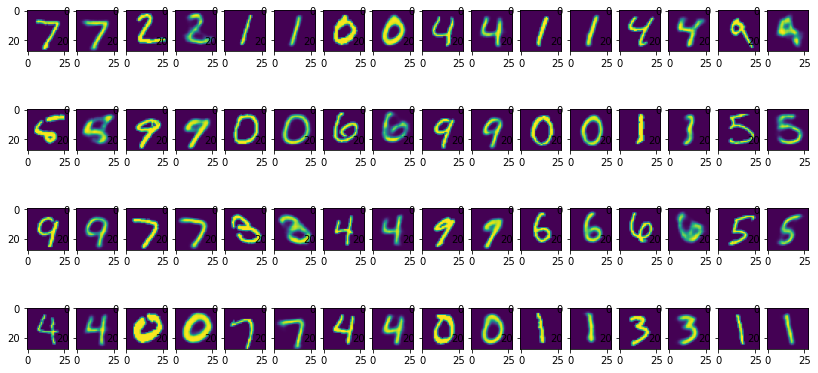

In [13]:
images, _ = iter(test).next()
_, ax = plt.subplots(4, 16, figsize = (14, 7))
with torch.no_grad():
    outputs, _, _ = model(images)

ax_flat = ax.flatten()
for i in range(0, len(ax_flat), 2):
    ax_flat[i+1].imshow(outputs[i//2][0].numpy())
    ax_flat[i].imshow(images[i//2][0].numpy())

In [11]:
if latent_dims == 2:
    grid_size = 16
    
    x, y = [torch.linspace(-3, 3, grid_size)] * 2
    latent_grid = torch.zeros((grid_size**2, 2))

    index = 0
    for i in x:
        for j in y:
            latent_grid[index, 0] = i
            latent_grid[index, 1] = j
            index += 1

    _, ax = plt.subplots(grid_size, grid_size, figsize = (14, 14))
    with torch.no_grad():
        outputs = model.decoder(latent_grid)

    ax_flat = ax.flatten()
    for i in range(len(ax_flat)):
        ax_flat[i].imshow(outputs[i][0].numpy())

In [12]:
if latent_dims == 2:
    x, y = {}, {}
    for i in range(10):
        x[f'tensor({i})'] = []
        y[f'tensor({i})'] = []

    with torch.no_grad():
        for imgs, labels in test:
            imgs = imgs.to(device)
            outputs, _, _ = model.encoder(imgs)
            for output, label in zip(outputs, labels):
                x[str(label)].append(output[0])
                y[str(label)].append(output[1])

    _, ax = plt.subplots(1, 1, figsize = (12, 12))
                
    for key in x:
        ax.scatter(x[key], y[key])